# Modélisation de la perfomance du portfolio

In [14]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import requests
from bs4 import BeautifulSoup
import math
from tqdm import tqdm
from itertools import islice
import seaborn as sns
import time

### Précicer les paths

In [128]:
# définir le path vers les 3 fichiers
path = r'...'


path_list = path + r'\List stock Paris.xlsx'
path_rend = path + r'\rendements.csv'
path_param = path + r'\param.csv'

In [69]:
# fonction requete pour yfinance
def get_stock(dico,final_tab):
    names,miss = list(dico.keys()), []
    for firm in tqdm(names):
        try:
            code = dico[firm]
            tick = yf.Ticker(code)
            hist = tick.history(period = 'max')
            hist.index = hist.index.strftime('%Y-%m-%d')
            hist = hist.loc['2000-01-03':'2023-12-31','Close']
            hist = hist.to_frame(name =firm)
            final_tab = pd.concat([final_tab,hist],axis = 1)
        except:
            miss.append(firm)
        time.sleep(0.5)
    return final_tab,miss

In [131]:
#On considère 900 stocks de euronext Paris

stock_list = pd.read_excel(path_list)
all_stocks = {}
for i in range(len(stock_list)):
    all_stocks[stock_list.iloc[i,1]] = stock_list.iloc[i,2] + ".PA"
    
len(all_stocks)

844

### Construction initiale de la table de rendements mensuels avec yfinance

In [71]:
# ## La première fois on reconstruit une table de valeurs de stocks à partir de yahoo finance

# tick = yf.Ticker('^N100')
# hist = tick.history(period = 'max')
# hist.index = hist.index.strftime('%Y-%m-%d')
# hist = hist.loc['1999-12-29':'2024-11-28','High']
# final_tab = hist.to_frame(name ='EURONEXT 100')
# final_tab,miss = get_stock(all_stocks,final_tab)
# final_tab.index = pd.to_datetime(final_tab.index)
# moyennes_mois = final_tab.resample('M').mean()
# rendements = moyennes_mois.pct_change().iloc[2:,:]

100%|████████████████████████████████████████████████████████████████████████████████| 844/844 [13:41<00:00,  1.03it/s]


In [72]:
# print (f'impossible de récupérer les données pour : {miss}')
# print(f'{len(rendements)} récupérée')
# rendements.head()

impossible de récupérer les données pour : ['Adux', 'Affluent Med Bsar', 'Ald', 'Algreen', 'Altur Invest.', 'Aperam', 'Apodaca Inversione', 'Aref Thalassa', 'Arverne Warrant', 'Astickso Xxi', 'Audience Labs', 'Barings Core Spain', 'Batla Minerals', 'Biophytis Bsa', 'Biosenic', 'Caire', 'Caterpillar Inc', 'Cbi Bsa', 'Celyad Oncology', 'Cgg', 'Cioa', 'Core Spain Holdco', 'Cybergun Bsa K1', 'Cybergun Bsa K2A', 'Cybergun Bsa K2B', 'Diagnostic Med Bsa', 'Dms Imaging', 'Drone Volt Bs26', 'Enertime', 'Eniblock', 'Erold', 'Esi Group', 'Euro Ressources', 'Eurolog Canola', 'Faifey Invest', 'Fermentalg', 'Fin.Etang Berre', 'Focusentertainment', 'General Electric', 'Genomic Vision', 'Glass To Power A', 'Glass To Power War', 'Global Pielago', 'Healthcare Activos', 'Hybrigenics', 'Inmark', 'Inmosupa', 'Ioc Holding', 'Iposa Properties', 'Itesoft', 'Jsa Technology', 'Mastrad Bs29', 'Mcphy Energy', 'Mdv', 'Media Maker', 'Mediocredito Europ', 'Meridia Re Iv', 'Mint', 'Mnd', 'Ok Properties', 'Ol Groupe',

,EURONEXT 100,1000Mercis,2Crsi,A.S.T. Groupe,Ab Science,Abc Arbitrage,Abeo,Abionyx Pharma,Abivax,Abl Diagnostics,...,Weya,Whiteni R Cajal,Winfarm,Witbe,Wiziboat,Worldline,X-Fab,Xilam Animation,Zccm,Zci Limited
Date,,,,,,,,,,,,,,,,,,,,,
2000-02-29,0.045453,NaN,NaN,NaN,NaN,0.246351,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-03-31,0.033593,NaN,NaN,NaN,NaN,-0.034140,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-04-30,-0.014503,NaN,NaN,NaN,NaN,-0.032412,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-05-31,0.029108,NaN,NaN,NaN,NaN,0.048729,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-06-30,0.029065,NaN,NaN,NaN,NaN,-0.030695,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [73]:
# #On ajoute les obligations du trésor français

# obli_1M = pd.read_excel(r'C:\Users\ludo1\OneDrive\Bureau\Nimp\France 1M bond.xlsx')
# obli_1M.set_index(obli_1M.columns[0], inplace=True)
# obli_1M.columns = ['Obli']

# obli = pd.concat([obli_1M.iloc[:,0], pd.Series([3.5] * 6)], ignore_index=True)
# obli = ((1 + obli/100)**(1/12) - 1).reset_index(drop=True)
# obli.index = rendements.index


# rendements['Obli'] = obli

# #On sauvegarde le fichier après cette première construction
# rendements.to_csv(r'C:\Users\ludo1\OneDrive\Documents\Centrale\Portfolio_management\rendements.csv', index=True)

### Utilisation de la table une fois construite

In [129]:
rendements = pd.read_csv(path_rend)

rendements.index = rendements['Date']
rendements = rendements.iloc[:,1:]
#On retrouve Euronext100 en première colonne et les obligations à la fin
rendements.head()

,EURONEXT 100,1000Mercis,2Crsi,A.S.T. Groupe,Ab Science,Abc Arbitrage,Abeo,Abionyx Pharma,Abivax,Abl Diagnostics,...,Whiteni R Cajal,Winfarm,Witbe,Wiziboat,Worldline,X-Fab,Xilam Animation,Zccm,Zci Limited,Obli
Date,,,,,,,,,,,,,,,,,,,,,
2000-02-29,0.045453,NaN,NaN,NaN,NaN,0.246351,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.002578
2000-03-31,0.033593,NaN,NaN,NaN,NaN,-0.034140,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.002683
2000-04-30,-0.014503,NaN,NaN,NaN,NaN,-0.032412,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.002831
2000-05-31,0.029108,NaN,NaN,NaN,NaN,0.048729,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003048
2000-06-30,0.029065,NaN,NaN,NaN,NaN,-0.030695,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003357


### Construction initiale de la table de parametre avec yfinance

In [84]:
stocks = list( rendements.columns)

#Exemple de récupération d'information avec info

ticker = all_stocks['1000Mercis']
tick = yf.Ticker(ticker)
info = tick.info

# Affichage de quelques caractéristiques importantes
print("Nom:", info['longName'])
print("Secteur:", info['sector'])
print("Industrie:", info['industry'])
print("Prix actuel:", info['currentPrice'])

# Indicateurs financiers importants
print("PER (Price-to-Earnings):", info.get('trailingPE'))
print("Ratio cours/valeur comptable (P/B):", info.get('priceToBook'))
print("Croissance du chiffre d'affaires:", info.get('revenueGrowth'))
print("Rendement du dividende:", info.get('dividendYield'))
print("ROE (Return on Equity):", info.get('returnOnEquity'))

Nom: 1000mercis
Secteur: Communication Services
Industrie: Advertising Agencies
Prix actuel: 30.0
PER (Price-to-Earnings): 20.134228
Ratio cours/valeur comptable (P/B): 3.9200313
Croissance du chiffre d'affaires: 0.012
Rendement du dividende: None
ROE (Return on Equity): 0.26943


In [82]:
# # Construction de la table avec yfinance

# donnees = []

# for s in tqdm(stocks):
#     try :
#         ticker = all_stocks[s]
#         tick = yf.Ticker(ticker)
#         info = tick.info

#         # Extraire les paramètres 
#         PE = info.get('trailingPE', None)
#         ROE = info.get('returnOnEquity', None)
#         growth = info.get('revenueGrowth', None)
#         div = info.get('dividendYield', None)
#         sec = info.get('sector',None)
#         PB = info.get('priceToBook',None)
#         beta = info.get('beta', None)
             

#         donnees.append([s, PE, ROE, growth, div,sec,PB,beta])
        
#     except Exception as e:
#         print(f"Erreur avec {s}: {e}")
#     time.sleep(1)
# param = pd.DataFrame(donnees, columns=['Entreprise', 'PER', 'ROE', 'Croissance CA', 'Dividende','Secteur','PB','beta'])
# param.set_index('Entreprise', inplace=True)

  0%|                                                                                          | 0/748 [00:00<?, ?it/s]

Erreur avec EURONEXT 100: 'EURONEXT 100'


100%|███████████████████████████████████████████████████████████████████████████████▉| 747/748 [14:03<00:01,  1.12s/it]

Erreur avec Obli: 'Obli'


100%|████████████████████████████████████████████████████████████████████████████████| 748/748 [14:04<00:00,  1.13s/it]


In [83]:
# #On sauvegarde aussi la table en local pour pouvoir l'utiliser rapidement

# param.to_csv(r'C:\Users\ludo1\OneDrive\Documents\Centrale\Portfolio_management\param.csv', index=True)

### On utilise la table de parametres sauvegardée

In [130]:
param = pd.read_csv(path_param)

param.index = param['Entreprise']
param = param.iloc[:,1:]
param.head()

,PER,ROE,Croissance CA,Dividende,Secteur,PB,beta
Entreprise,,,,,,,
1000Mercis,20.134228,0.26943,0.012,NaN,Communication Services,3.920031,0.643
2Crsi,NaN,NaN,-0.883,0.1042,Technology,2.018682,2.708
A.S.T. Groupe,NaN,-0.87685,0.211,NaN,Consumer Cyclical,0.436594,1.418
Ab Science,NaN,NaN,0.250,NaN,Healthcare,NaN,1.193
Abc Arbitrage,17.089285,0.10401,0.126,0.0839,Financial Services,1.797521,0.247


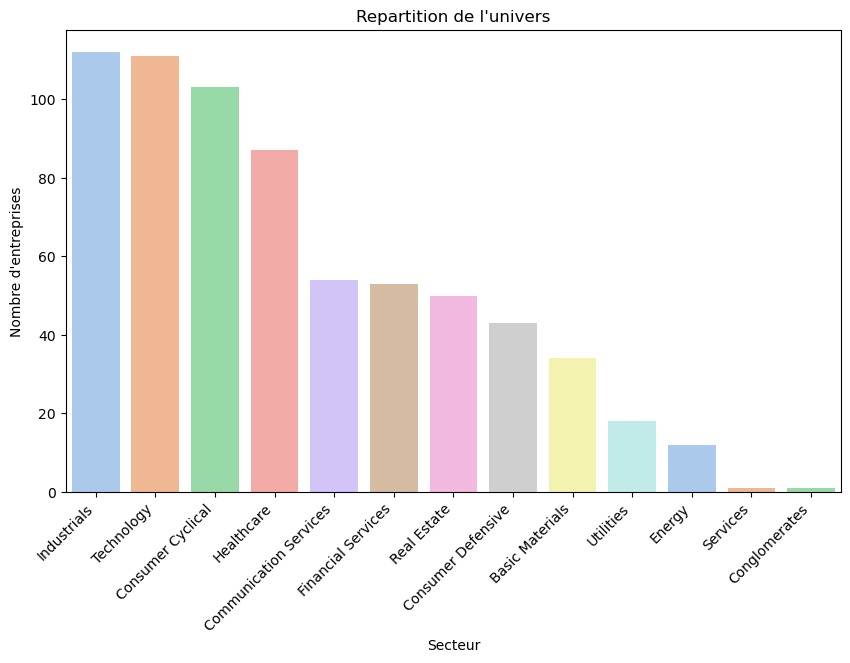

In [87]:
plt.figure(figsize=(10, 6))
sns.countplot(data=param, x='Secteur', palette='pastel', order=param['Secteur'].value_counts().index)

plt.title("Repartition de l'univers")
plt.xlabel("Secteur")
plt.ylabel("Nombre d'entreprises")
plt.xticks(rotation=45, ha='right')
plt.show()

In [88]:
# On enleve les valeurs inscencées de la table

param = param[(param['beta'] >= -5) & (param['beta'] <= 10)]
param = param[(param['PB'] >= -10) & (param['PB'] <= 10)]
param = param[(param['ROE'] >= -1) & (param['ROE'] <= 1)]
param = param[(param['Croissance CA'] >= -1) & (param['Croissance CA'] <= 1.5)]

print(len(param))

414


### Qq plot sur toutes les entreprises récupéres

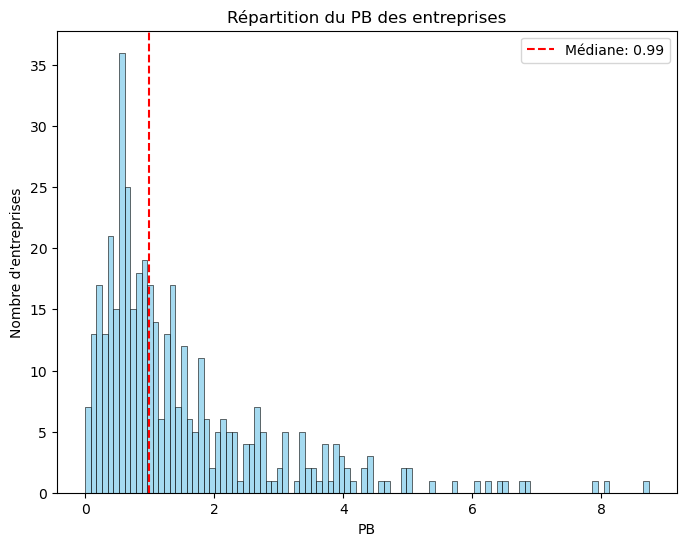

In [89]:
# Choisir la variable d'intéret parmis: PER	ROE	Croissance CA	Dividende PB	beta
var = 'PB'

plt.figure(figsize=(8, 6))
sns.histplot(param[var].dropna(), bins=100, kde=False, color='skyblue')
#plt.xlim(-1, 8)
mediane_roe = param[var].dropna().median()
plt.axvline(mediane_roe, color='red', linestyle='--', label=f'Médiane: {mediane_roe:.2f}')


plt.title(f'Répartition du {var} des entreprises')
plt.xlabel(var)
plt.ylabel("Nombre d'entreprises")
plt.legend()
plt.show()

### Selection des entreprises en fonction de leurs caractéristiques

In [90]:
# Sélection des actions contracyclique
safe_sectors = ['Consumer Defensive', 'Healthcare', 'Utilities']

actions_contracy = param[(param['beta'] < 0.5) & 
                         (param['beta'] >= -1) &
                         (param['ROE'] >= 0.10) &
                         (param['Secteur'].isin(safe_sectors))
                        ].index.tolist()
len(actions_contracy)

7

In [91]:
# Sélection des actions growth

actions_growth = param[ 
    (param['ROE'] > 0.15) & 
    (param['Croissance CA'] > 0.07)
].index.tolist()

len(actions_growth)

29

In [92]:
#Selection des actions value
actions_value = param[ 
    (param['PB'] <= 1.5) & 
    (param['ROE'].between(0.10, 0.20)) & 
    (param['beta'].between(0.5, 1.5))
].index.tolist()

len(actions_value)

38

In [93]:
obligations = ['Obli']

### La répartition sectorielle dans le portfolio

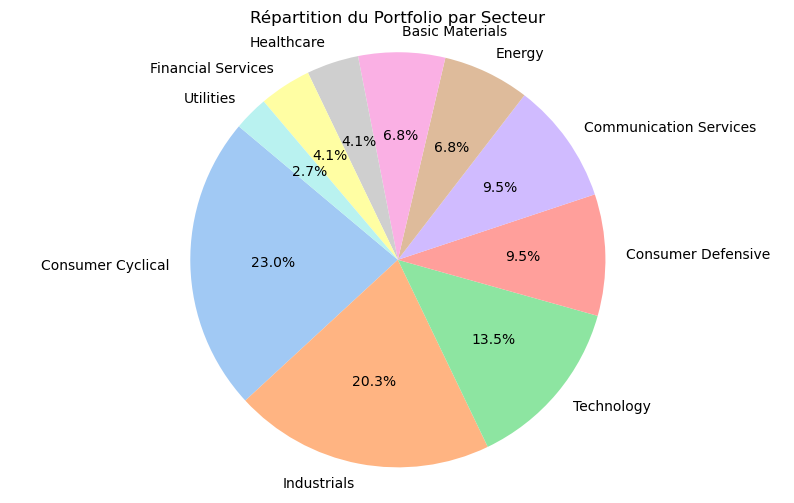

In [94]:
secteurs = param.loc[actions_contracy + actions_value + actions_growth, 'Secteur']

secteurs_count = secteurs.value_counts()

#Cmaenbert
plt.figure(figsize=(10, 6))
plt.pie(secteurs_count, labels=secteurs_count.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel', len(secteurs_count)))

plt.title("Répartition du Portfolio par Secteur")
plt.axis('equal')  # Pour un camembert circulaire
plt.show()

### Calcul des indicateurs clés du portfolio

#### Sélection de la fenetre de temps

In [158]:
# 0 -> 02/2000; 48 -> 04/2004 ; 120 -> 01/2010; 180 -> 2015; 240 -> 2020; 298 -> 11/2024

start = 230
end = 298

date = rendements.index[start:end]
print (f'Etude du {date[0]} au {date[-1]}')

Etude du 2019-04-30 au 2024-11-30


In [159]:
poids = {
    "growth": 0.2,
    "value": 0.4,
    "contracyclique": 0.2,
    "obligations": 0.2
}

In [160]:
# Rendement mensuels

rendement = (
    rendements.loc[date, actions_growth].mean(axis=1) * poids["growth"] +
    rendements.loc[date,actions_value].mean(axis=1) * poids["value"] +
    rendements.loc[date,actions_contracy].mean(axis=1) * poids["contracyclique"] +
    rendements.loc[date,obligations].mean(axis=1) * poids["obligations"]
)

### Calcul des indices (rendements/vol/sharpe/VaR) pour le portfolio

In [161]:
# Valeur du portfolio dans le temps

valeur = (1 + rendement).cumprod()

#Calcul du rendement annualisé
perf = valeur.iloc[-1] - 1
perf_an = (1 + perf) ** (12 / len(date)) - 1
print(f'rendement annualisé : {perf_an}')

#Calcul de la volatilité annualisé 
vol = rendement.std() * np.sqrt(12)
print (f'volatilité : {vol}')

#ratio de sharpe
taux_sans_risque = 0.02  # Exemple annuel
sharpe = (rendement.mean() * 12 - taux_sans_risque) / vol
print (f'Sharpe : {sharpe}')

#Calcul VaR
var = -(perf_an/12 + 1.645*vol/np.sqrt(12))
print (f'VaR mensuelle : {var}')

rendement annualisé : 0.07829233779624811
volatilité : 0.10260831198617743
Sharpe : 0.5946966331205807
VaR mensuelle : -0.05525003179236283


### Calcul des indices (rendements/vol/sharpe/VaR) pour Euronext 100

In [162]:
euro100 = rendements.loc[date,'EURONEXT 100']
v100 = (1+euro100).cumprod()
perf100 = v100.iloc[-1] - 1
perf_an100 = (1 + perf100) ** (12 / len(date)) - 1

vol100 = euro100.std() * np.sqrt(12)
print(f'rendement annualisé : {perf_an100}')
print (f'volatilité : {vol100}')

taux_sans_risque = 0.02  # Exemple annuel
sharpe100 = (euro100.mean() * 12 - taux_sans_risque) / vol100
print (f'Sharpe : {sharpe100}')

#Calcul VaR
var100 = -(perf_an100/12 + 1.645*vol100/np.sqrt(12))
print (f'VaR : {var100}')

rendement annualisé : 0.061067356903222736
volatilité : 0.14277275958191052
Sharpe : 0.35152587435655147
VaR : -0.07288753190214645


In [137]:
## Comparaison avec le CAC40
# CAC = rendements.loc[date,'CAC40']
# v100 = (1+euro100).cumprod()
# perf100 = v100.iloc[-1] - 1
# perf_an100 = (1 + perf100) ** (12 / len(date)) - 1

# vol100 = euro100.std() * np.sqrt(12)
# print(f'rendement annualisé : {perf_an100}')
# print (f'volatilité : {vol100}')

### Plot de la performance du portefeuille sur les dates définies

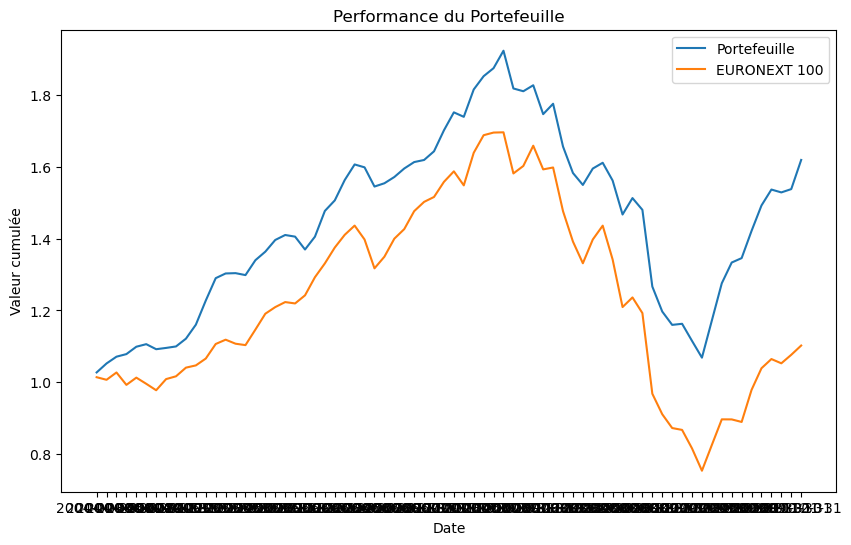

In [138]:
plt.figure(figsize=(10, 6))
plt.plot(valeur, label="Portefeuille")
plt.plot(v100, label="EURONEXT 100")
plt.title("Performance du Portefeuille")
plt.xlabel("Date")
plt.ylabel("Valeur cumulée")
plt.legend()
plt.show()